# MASK R-CNN

Mask R-CNNs are region-CNNs (R-CNNs) that detect objects in images and provide instance-segmentation masks in addition to bounding boxes. The benefit of segmentation masks is that they provide more detail about the objects in an image. For example, you can tell whether a person’s arms are extended or whether that person is standing up or lying down – something you can’t discern from a simple bounding box. Instance segmentation is the reason Zoom can display custom backgrounds behind you in video feeds. It’s also what powers AI-based image-editing tools that crop figures from the foreground and place them on different backgrounds.

Let's use a [pretrained Mask R-CNN](https://github.com/onnx/models/tree/main/vision/object_detection_segmentation/mask-rcnn) provided as an ONNX file in the [ONNX Model Zoo](https://github.com/onnx/models) on GitHub to detect objects in an image, show bounding boxes and segmentation masks, and copy objects in the image to another image. Start by loading an image.

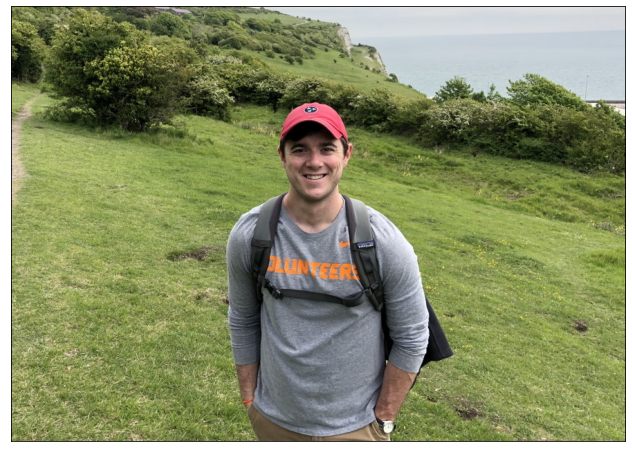

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('Data/adam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

Preprocess the image pixels the way the model expects, load the model from the ONNX file, and submit the preprocessed image to it:

In [2]:
from mask import *
import onnxruntime as rt

image_data = preprocess(image)
session = rt.InferenceSession('Data/MaskRCNN-12-int8.onnx')
input_name = session.get_inputs()[0].name
result = session.run(None, { input_name: image_data })

Grab the bounding boxes, predicted class labels, confidence scores, and segmentation masks and pass them to the `annotate_image` helper function in **mask.py** to visualize the results:

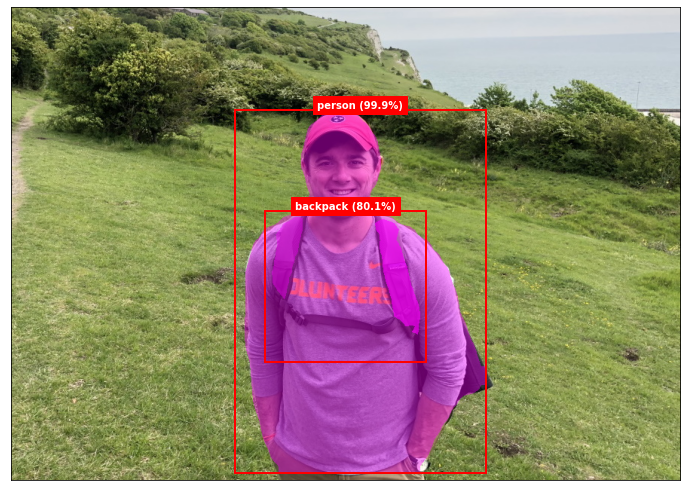

In [3]:
boxes = result[0]  # Bounding boxes
labels = result[1] # Class labels
scores = result[2] # Confidence scores
masks = result[3]  # Segmentation masks

annotate_image(image, boxes, labels, scores, masks)

By default, `annotate_image` ignores objects identified with less than 70% confidence. (You can override that by passing a `min_confidence` parameter in the call.) The model detected two objects in the image with a confidence that equaled or exceeded 70%: a person and a backpack. `annotate_image` draws the bounding boxes and annotates them with class names and confidence levels. It also shades the objects the model detected using partially transparent pixels. These are the segmentation masks returned by `run`.

**mask.py** also contains a `change_background` function that extracts all the objects detected in an image with a specified confidence level (default = 0.7) and composites them onto a new background. To demonstrate, load two images and pass them to `change_background`:

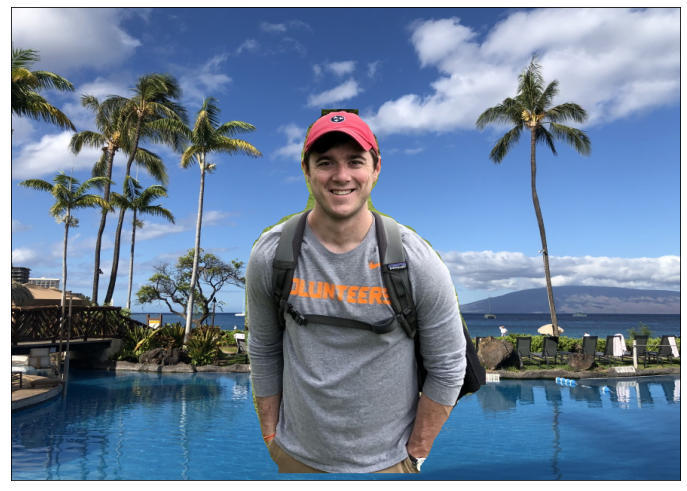

In [4]:
fg_image = Image.open('Data/adam.jpg')
bg_image = Image.open('Data/maui.jpg')

change_background(session, fg_image, bg_image)

`change_background` works by submitting the foreground image (the one passed in the function’s second parameter) to the model, converting all the pixels outside the segmentation masks into transparent pixels, and overlaying the result on the background image. It works best when the foreground and background images are the same size, but it will resize the background image if needed to match the foreground image. The background will be distorted if its aspect ratio differs from that of the foreground image.